# Elevation Cleaning
In this code we walk through cleaning up the sampled elevation data from DEMs, including resampling bridge deck elevations from lidar where needed.

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import geometry_mask
from rasterio.plot import show
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping
from shapely.ops import Point
from tqdm import tqdm
import pyproj
import math
from shapely.ops import LineString
import pickle
import contextily as cx

from whittaker_eilers import WhittakerSmoother

In [2]:

#import network
network_filepath= Path.home() / 'Documents/BikewaySimData/Projects/gdot/networks'

#import network
links = gpd.read_file(network_filepath/'filtered.gpkg',layer='links')
#links = gpd.read_file(network_filepath/ 'reconciled_network.gpkg',layer='links_w_signals')
links.set_index('osm_linkid',drop=False,inplace=True)
prev_crs = links.crs

tiff_links = list(Path('D:/dem_files').glob('*.tif'))

#open the first one to just get the crs
src = rasterio.open(tiff_links[0])
dem_crs = src.crs
src.close()

links.to_crs(dem_crs,inplace=True)

Import sampled elevation data

In [3]:
#for storing the interpolated points with sampled elevation data
with (network_filepath.parent/'elevation.pkl').open('rb') as fh:
    interpolated_points_dict = pickle.load(fh)

In [4]:
def elevation_stats(distances,elevations,grade_threshold,key_prefix=''):
    
    #find the total distance to get average grade
    total_distance = distances.max()
    
    #caluclate the elevation change between points and add to list
    elevation_deltas = np.diff(elevations)
    distance_deltas = np.diff(distances)
    
    segment_grades = elevation_deltas / distance_deltas * 100
    bad_ascent_grades = np.flatnonzero(segment_grades > grade_threshold)
    bad_descent_grades = np.flatnonzero(segment_grades < -grade_threshold)

    # #get total ascent and descent
    ascent = elevation_deltas[elevation_deltas > 0].sum()
    descent = elevation_deltas[elevation_deltas < 0].sum()

    #get average ascent and descent grade over link distance
    ascent_grade = np.round(ascent / total_distance * 100,2)
    descent_grade = np.round(descent / total_distance * 100,2)

    outputs = {
        f'{key_prefix}ascent': ascent, # total rise
        f'{key_prefix}descent':descent, # total descent
        f'{key_prefix}ascent_grade': ascent_grade, # average ascent grade over link length
        f'{key_prefix}descent_grade': descent_grade, # average descent grade over link length
        f'{key_prefix}bad_ascent_grades': bad_ascent_grades, # index of segments that exceed the specified grade_threshold
        f'{key_prefix}bad_descent_grades': bad_descent_grades, # index of segments that exceed the specified grade_threshold
        f'{key_prefix}elevation_deltas': elevation_deltas,
        f'{key_prefix}distance_deltas': distance_deltas,
        f'{key_prefix}segment_grades': segment_grades,
    }

    return outputs



In [5]:
#start with something really high, we want to know when there's a drastic jump
grade_threshold = 15

# for linkid, item in interpolated_points_dict.items():     

#     outputs = elevation_stats(item['distances'],item['elevations'],grade_threshold)

#     interpolated_points_dict[linkid].update(
#             {
#                 'ascent': ascent, 
#                 'descent': descent, 
#                 'ascent_grade': ascent_grade, 
#                 'descent_grade': descent_grade, 
#                 'bad_ascent_grades': bad_ascent_grades, # index of segments that exceed the specified grade_threshold
#                 'bad_descent_grades': bad_descent_grades
#             }
#         )

# Visualization Function
This function takes a list of linkids and accesses items from interpolated_points_dict to make a plot showing 1) the vertical profile 2) the horizontal alignment with a satellite basemap, and 3) the horizontal alignment with a streets basemap. Nodes exceeding the grade threshold (going in the foward direction are highlighted).

In [6]:
#code credit
#https://github.com/geopandas/geopandas/issues/2279
#https://stackoverflow.com/questions/8247973/how-do-i-specify-an-arrow-like-linestyle-in-matplotlib
from IPython.display import display, clear_output

def visualize(list_of_linkids,export_filepath,one_off=False,lidar=False,smoothed=False):

    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

    for linkid in list_of_linkids:

        item = interpolated_points_dict[linkid]

        #Extract values
        x = item['distances']
        y = item['elevations']
        points = np.array([Point(x,y) for x,y in item['geometry']])
        line = LineString(item['geometry'])
        minx, miny, maxx, maxy = line.bounds

        # Plot the original data and the smoothed curve
        ax1.plot(x, y, 'o', label='DEM Data')

        # key_prefix = ''
        # if lidar:
        #     key_prefix = 'lidar_'
        # if smoothed:
        #     key_prefix = 'smoothed_'
        output = elevation_stats(x,y,grade_threshold)

        #Highlight bad grades
        if (len(output['bad_ascent_grades']) > 0) | (len(output['bad_descent_grades']) > 0):

            bad_ascent_grades = output['bad_ascent_grades']
            bad_descent_grades = output['bad_descent_grades']

            #get positions for highlighting grades
            bad_ascent_grades = np.unique(np.hstack([bad_ascent_grades,bad_ascent_grades - 1]))
            bad_descent_grades = np.unique(np.hstack([bad_descent_grades,bad_descent_grades - 1]))
            bad_ascent_x = x[bad_ascent_grades]
            bad_ascent_y = y[bad_ascent_grades]
            bad_descent_x = x[bad_descent_grades]
            bad_descent_y = y[bad_descent_grades]
        
            # plot bad points
            ax1.plot(bad_ascent_x,bad_ascent_y,'o',color='green',label=f'Above {grade_threshold}%')
            ax1.plot(bad_descent_x,bad_descent_y,'o',color='red',label=f'Below -{grade_threshold}%')

            #TODO change to highlight the segment that's bad (both points)
            # use mask to just get bad one
            bad_ascent_grades_points = points[bad_ascent_grades]
            bad_ascent_grades_points = gpd.GeoDataFrame({'geometry':bad_ascent_grades_points},geometry='geometry',crs=dem_crs)
            bad_ascent_grades_points['type'] = f'> {grade_threshold}%'

            bad_descent_grades_points = points[bad_descent_grades]
            bad_descent_grades_points = gpd.GeoDataFrame({'geometry':bad_descent_grades_points},geometry='geometry',crs=dem_crs)
            bad_descent_grades_points['type'] = f'< -{grade_threshold}%'

            bad_grades_points = pd.concat([bad_ascent_grades_points,bad_descent_grades_points])

            color_dict = {
                f'> {grade_threshold}%': 'green',
                f'< -{grade_threshold}%': 'red',
            }
            bad_grades_points['color'] = bad_grades_points['type'].map(color_dict)

            bad_grades_points.plot(ax=ax2,color=bad_grades_points['color'],zorder=4)
            bad_grades_points.plot(ax=ax3,color=bad_grades_points['color'],zorder=4)

        #TODO recalculate bad grades for each to include
        #TODO have it only show new lidar values
        if lidar:
            lidar_y = item['lidar']
            mask = y != lidar_y
            ax1.plot(x[mask], lidar_y[mask], 'x',label='Resampled with Lidar')

        if smoothed:
            smoothed_y = item['smoothed']
            ax1.plot(x, smoothed_y, '+',label='Smoothed')
        
        ax1.grid(True,linestyle='-.')
        ax1.set_xlabel('Distance (m)')
        ax1.set_ylabel('Elevation (m)')
        ax1.legend()

        #Second and Third figure
        #for drawing the link
        x_coord = np.array([x for x, y in item['geometry']])
        y_coord = np.array([y for x, y in item['geometry']])
        
        # ARROW CODE
        # length of line segment
        ds=10
        # number of line segments per interval
        Ns = np.round(np.sqrt( (x_coord[1:]-x_coord[:-1])**2 + (y_coord[1:]-y_coord[:-1])**2 ) / ds).astype(int)
        # sub-divide intervals w.r.t. Ns
        subdiv = lambda z, Ns=Ns: np.concatenate([ np.linspace(z[ii], z[ii+1], Ns[ii]) for ii, _ in enumerate(z[:-1]) ])
        x_coord, y_coord = subdiv(x_coord), subdiv(y_coord)
        ax2.quiver(x_coord[:-1], y_coord[:-1], x_coord[1:]-x_coord[:-1], y_coord[1:]-y_coord[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=4, headwidth=4)
        ax3.quiver(x_coord[:-1], y_coord[:-1], x_coord[1:]-x_coord[:-1], y_coord[1:]-y_coord[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=4, headwidth=4)

        #If you want a legend for map (didnot figure out arrow in the legend)
        # from matplotlib.lines import Line2D
        # from matplotlib.patches import Arrow
        # custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
        # #custom_line = Arrow(0,0,dx=0.1,dy=0,width=0.1,linewidth=0.5,color='black')
        # #custom_points.append()
        # leg_points = ax2.legend(custom_points, ['> 15%','< -15%'])#, title = 'Legend', alignment='right')
        # ax2.add_artist(leg_points)

        #make sure fig is square
        padding = 100
        x_diff = np.abs(maxx - minx)
        y_diff = np.abs(maxy - miny)
        diff = (x_diff - y_diff)/2
        if diff > 0:
            ax2.set_xlim(minx-padding,maxx+padding)
            ax2.set_ylim(miny-padding-diff,maxy+padding+diff)

            ax3.set_xlim(minx-padding,maxx+padding)
            ax3.set_ylim(miny-padding-diff,maxy+padding+diff)
        else:
            ax2.set_xlim(minx-padding-np.abs(diff),maxx+padding+np.abs(diff))
            ax2.set_ylim(miny-padding,maxy+padding)

            ax3.set_xlim(minx-padding-np.abs(diff),maxx+padding+np.abs(diff))
            ax3.set_ylim(miny-padding,maxy+padding)

        ax2.set_axis_off()
        ax3.set_axis_off()

        cx.add_basemap(ax2,zoom=17,source=cx.providers.MapTiler.Satellite(key=maptilerapikey),crs=links.crs,alpha=0.5)
        cx.add_basemap(ax3,zoom=16,source=cx.providers.MapTiler.Streets(key=maptilerapikey),crs=links.crs)

        #maybe if we wanted a high res version of this later
        #https://stackoverflow.com/questions/42483449/mapbox-gl-js-export-map-to-png-or-pdf

        name = links.loc[links['linkid']==linkid,'name'].item()
        plt.suptitle(f'{name} ({linkid}) vertical profile (avg ascent grade = {output['ascent_grade']}, descent grade = {output['descent_grade']})')
        
        #just display that one
        if one_off:  
            plt.show()
        else: 
            try: 
                plt.savefig(export_filepath / f"{name}_{linkid}.png",dpi=300)
            except:
                plt.savefig(export_filepath / f"{linkid}.png",dpi=300)
            #clear the axes for next figure
            ax1.cla()
            ax2.cla()
            ax3.cla()

## Linkids with a segment exceeding the grade threshold

In [7]:
exceeds_threshold = []
for key, item in interpolated_points_dict.items():
    output = elevation_stats(item['distances'],item['elevations'],grade_threshold)
    if len(output['bad_ascent_grades']) > 0 | len(output['bad_descent_grades']):
        exceeds_threshold.append(key)

print(len(exceeds_threshold),'exceed the threshold')
exceeds_threshold = links.loc[exceeds_threshold]

#grab ones that are not bridges and don't exceed the threshold
not_bridges = exceeds_threshold.loc[exceeds_threshold['bridge'].isna(),['linkid','geometry']]
print(len(not_bridges),'of thse are not tagged as bridges')

1877 exceed the threshold
1758 of thse are not tagged as bridges


## Find Underpasses (don't use lidar with these)
- Should have a distinct section that's high above everything else
Need to also bring in railroads
- Can also be tagged as tunnels

In [8]:
#grab bridges
raw_osm = gpd.read_file(network_filepath/'filtered.gpkg',layer='osm_links')
osm_attr = pd.read_pickle(network_filepath/'osm_attr.pkl')
merged = raw_osm.merge(osm_attr,on='osm_linkid')
bridges = merged.loc[~merged['bridge'].isna(),['osm_linkid','geometry']]
bridges.to_crs(links.crs,inplace=True)

In [9]:
#check if bridge crosses non-bridge (won't include where a link connects to a bridge)
crossing_links = []
for idx, row in bridges.iterrows():
    bridge = row['geometry']
    crosses = not_bridges.loc[not_bridges.crosses(bridge),'linkid'].tolist()
    if len(crosses) > 0:
        crossing_links = crossing_links + crosses
mask = list(set(crossing_links))

#add tunnels into this
mask.append(links.loc[links['tunnel'].isna(),'linkid'].tolist())

In [10]:
item.keys()

dict_keys(['geometry', 'distances', 'elevations'])

In [11]:
#remove up/down part
#for linkid in mask:
linkid = 28179

item = interpolated_points_dict.get(linkid,0)


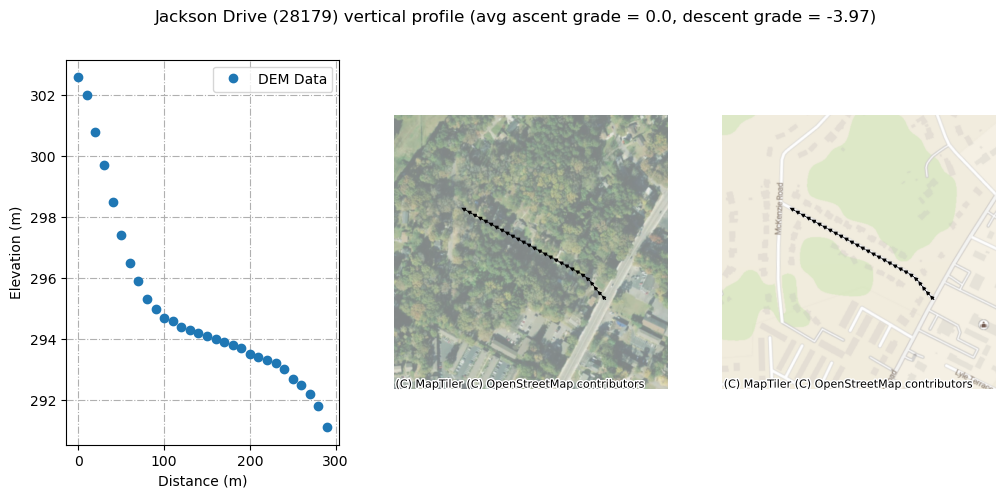

In [12]:
visualize([linkid],None,one_off=True)

One of smoothing 

In [13]:

# # if item == 0:
# #     print('error')
# #     continue

# x = item['distances']
# segment_grades = np.array(item['segment_grades'])
# elevations = np.array(item['elevations'])
# weights = np.ones_like(elevations)

# #knockout
# #while (np.abs(segment_grades) > grade_threshold).any():

# big_up = (segment_grades > grade_threshold).argmax()
# big_down = (segment_grades < -grade_threshold).argmax()


# #only a big up (just eliminate everything after)

# #only a big down (just eliminate everything before)

# #scenario 1: underpass is in the middle of the segment
# if big_up < big_down:
    
#     #adjust to index elevations
#     weights[big_up:big_down+1] = 0
    
# #scenario 2: underpass is at the beginning of a segment
# #if no big_up
    
# #scenario 3: 


# whittaker_smoother = WhittakerSmoother(
#     lmbda=1e2,#higher will turn it into a linear line
#     order=2, #higher will make it better follow the troughs/peaks
#     weights = weights, # zero means interporlate less than 1 puts less trust in point
#     data_length=len(elevations)
#     )

# #smoothed = whittaker_smoother.smooth(elevations)
# optimal_smooth = whittaker_smoother.smooth_optimal(elevations).get_optimal().get_smoothed()

# #get average grade
# up_grade = 
# down_grade = 
# fig, ax = plt.subplots()

# ax.plot(x,elevations)
# #ax.plot(x,smoothed,'x')
# ax.plot(x,optimal_smooth,'+')

## Sample bridge decks (use lidar here)

In [14]:
exceeds_threshold_not_underpass = exceeds_threshold.loc[~exceeds_threshold.index.isin(mask)]

In [15]:
with Path('D:/lidar_points.pkl').open('rb') as fh:
    lidar_points = pickle.load(fh)

lidar_points.to_crs(dem_crs,inplace=True)
spatial_index = lidar_points.sindex

In [16]:
lidar_found = []

for linkid in tqdm(exceeds_threshold_not_underpass.index):
    
    item = interpolated_points_dict.get(linkid)

    geometry = [Point(x,y) for x,y in item['geometry']]
    gdf = gpd.GeoDataFrame({'geometry':geometry},crs=dem_crs)
    #gdf.to_crs(,inplace=True)

    #buffer the data
    buffer_m = 20
    gdf.geometry = gdf.buffer(buffer_m)

    #get the gdf bounding box
    polygon = gdf.geometry.unary_union.convex_hull
    
    #use spatial index to only select a small number of points
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    possible_matches = lidar_points.iloc[possible_matches_index]
    
    #add an index column for the overlay part
    gdf.reset_index(inplace=True)
    precise_matches = gpd.overlay(possible_matches,gdf,how='intersection')

    #if no matches found take no action
    if len(precise_matches) == 0:
        continue
    else:
        lidar_found.append(linkid)

    #take average of all nearby values
    new_values = precise_matches.groupby('index')['elevation_m'].mean()
    gdf['new_elevation_m'] = gdf['index'].map(new_values)
    new_values = np.array(gdf['new_elevation_m'])

    no_lidar = np.isnan(new_values).sum()

    #use nanmax
    new_values = np.nanmax([new_values,item['elevations']],axis = 0)

    output = elevation_stats(item['distances'],new_values,grade_threshold)

    #assign new entry in the dictionary
    interpolated_points_dict[linkid].update({
        'lidar': new_values,
        'no_lidar': no_lidar,
        'lidar_ascent': output['ascent'],
        'lidar_descent': output['descent'], 
        'lidar_ascent_grade': output['ascent_grade'],
        'lidar_descent_grade': output['descent_grade'],
        'lidar_bad_ascent_grades': output['bad_ascent_grades'],
        'lidar_bad_descent_grades': output['bad_descent_grades']
    })

  0%|          | 0/1867 [00:00<?, ?it/s]

100%|██████████| 1867/1867 [00:59<00:00, 31.60it/s]


In [17]:
del lidar_points

In [18]:
# visualize(lidar_found,Path('D:/vert_profiles/lidar'),lidar=True)

# Smooth with [Whittaker-Eilers Method](https://towardsdatascience.com/the-perfect-way-to-smooth-your-noisy-data-4f3fe6b44440)

In [19]:
for linkid, item in interpolated_points_dict.items():
    
    distances = np.array(item['distances'])
    
    if linkid in lidar_found:
        elevations = np.array(item['lidar'])
    else: 
        elevations = np.array(item['elevations'])

    whittaker_smoother = WhittakerSmoother(
    lmbda=150, order=2, data_length=len(elevations)
    )

    smoothed = whittaker_smoother.smooth(elevations)

    output = elevation_stats(distances,smoothed,grade_threshold)

    #assign new entry in the dictionary
    interpolated_points_dict[linkid].update({
        'smoothed': smoothed,
        'smoothed_ascent': output['ascent'],
        'smoothed_descent': output['descent'], 
        'smoothed_ascent_grade': output['ascent_grade'],
        'smoothed_descent_grade': output['descent_grade'],
        'smoothed_bad_ascent_grades': output['bad_ascent_grades'],
        'smoothed_bad_descent_grades': output['bad_descent_grades'],
        'smoothed_segment_grades': output['segment_grades']
    })


In [20]:
# linkid = 28689
# item = interpolated_points_dict[linkid]

# distances = np.array(item['distances'])
# elevations = np.array(item['elevations'])
# bad_elevs = item['bad_grades']
# #temp_anom = [-0.17, -0.09, -0.11, -0.18, -0.3] # and so on...

# # further step could be to identify the high points and assign a lower weight 
# weights = np.ones_like(elevations)
# weights[elevations>311] = 0

# whittaker_smoother = WhittakerSmoother(
#     lmbda=150, order=2, data_length=len(elevations)#, weights=weights
# )

# smoothed = whittaker_smoother.smooth(elevations)

# plt.plot(distances,elevations)
# plt.plot(distances,smoothed)

# Plot Results

In [21]:
#visualize(mask,Path('D:/vert_profiles/underpasses'),smoothed=True)
# visualize(mask,Path('D:/figures/lidar_smoothed'),smoothed=True)

# Measuring Grade
Length of grade + grade matters. Grade is change in elevation over a length of road. 
- Grade can be averaged over the entire link (seperating up and down)
- Grade can be averaged over the just the section of up or down (expected grade going uphill)
- Grade can be categorized (>3%, >6,% >10,etc) and the length in each category could be calculated

If we're just concerned about the impact on travel time then an average value is probably fine, but if we're more concerned about a preference then categorizing and finding the lengths of each is probably more useful.

In route choice literature, they're either look at the average grade of the entire route (Hood 2011, Prato 2018) or break it into categories (proportion of the route 2-4% grade) (Broach 2012). Since we're estimating link level impedances, we can be flexible and avoid taking averages if desired.

Broach:
- 2-4%
- 4-6%
- more than 6%

In [22]:
# linkid = 44611#47488#67089
# item = interpolated_points_dict[linkid]
# visualize([linkid],Path.home()/'Downloads',smoothed=True)
# np.array(item['smoothed_segment_grades']).max()

## Add to network

In [23]:
grade_cats = {}

for linkid, item in tqdm(interpolated_points_dict.items()):     

    outputs = elevation_stats(item['distances'],item['smoothed'],grade_threshold)

    df = pd.DataFrame({
        'distance_deltas':outputs['distance_deltas'],
        'segment_grades':outputs['segment_grades']
        })
    #create bins (broach 2012 ones)
    #'(-inf,-6]','(-6,-4]','(-4,-2]','(-2,0]',
    #-np.inf,-6,-4,-2,
    bins = [-1,2,4,6,10,15,np.inf]
    names = ['(0,2]','(2,4]','(4,6]','(6,10]','(10,15]','(15,inf]']
    df['grade_category'] = pd.cut(df['segment_grades'].abs(), bins, labels = names)

    #determine if up or down (doesn't matter if flat)
    df.loc[df['segment_grades'] >= 0,'ascent_or_descent'] = 'ascent'
    df.loc[df['segment_grades'] < 0,'ascent_or_descent'] = 'descent'

    # how many meters at each grade category?
    test = df.groupby(['grade_category','ascent_or_descent'],observed=False)['distance_deltas'].sum().round(0)
    test = pd.DataFrame(test).transpose()
    test.index = [linkid]
    grade_cats[linkid] = {
        'ascent_m': outputs['ascent'],
        'descent_m': outputs['descent'],
        'ascent_grade': outputs['ascent_grade'],
        'descent_grade': outputs['descent_grade']
    }
    grade_cats[linkid].update(
        test.to_dict(orient='records')[0]
    )
    
#.items())#.reseorient='t_index()#.pivot(
    # columns=['grade_category','up'],
    # values='distance_deltas'
    # )
#grade_cats

  0%|          | 0/169243 [00:00<?, ?it/s]

 46%|████▋     | 78593/169243 [05:25<05:58, 252.79it/s]

: 

In [ ]:
#TODO fix ascent/descent here
df2 = pd.DataFrame.from_dict(grade_cats,orient='index')
df2.columns = ['_'.join(col) for col in df2.columns]
df2
df2.fillna(0,inplace=True)

In [ ]:
final = pd.merge(links,df2,left_index=True,right_index=True)


In [ ]:
final.loc[(final['(15,inf]_ascent']>10) | (final['(15,inf]_descent']>10),['name','(15,inf]_ascent','(15,inf]_descent','geometry']].explore()

In [ ]:
final.reset_index(drop=True).to_file(network_filepath/'elevation_added.gpkg',layer='links')

In [ ]:
final

,linkid,A,B,osmid,link_type,name,highway,oneway,bearing,bridge,...,"(4,6]_descent","(6,10]_descent","(10,15]_descent","(15,inf]_descent","(0,2]_ascent","(2,4]_ascent","(4,6]_ascent","(6,10]_ascent","(10,15]_ascent","(15,inf]_ascent"
0.0,0.0,67358019,67358015,9.106163e+06,road,Rocklane Drive,residential,0,178.5,None,...,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,1.0,67358022,67358019,9.106163e+06,road,Rocklane Drive,residential,0,178.5,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2.0,2.0,67358027,67358022,9.106163e+06,road,Rocklane Drive,residential,0,178.5,None,...,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0
3.0,3.0,67358031,67358027,9.106163e+06,road,Rocklane Drive,residential,0,178.5,None,...,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
4.0,4.0,67421931,67358019,9.111365e+06,road,Winmar Lane,residential,0,91.5,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71290.0,71290.0,11399225897,11399225894,1.229184e+09,bike,None,path,0,220.8,None,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71291.0,71291.0,11399225897,11399225895,1.229184e+09,bike,None,path,0,148.9,None,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71292.0,71292.0,11399225894,11399225893,1.229184e+09,bike,None,steps,0,58.8,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71293.0,71293.0,11399225895,11399225894,1.229184e+09,bike,None,path,0,25.4,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#find the total distance to get average grade
    #total_distance = np.array(item['distances']).max()
    

    # #caluclate the elevation change between points and add to list
    # elevation_deltas = []
    # grades = []
    # bad_grades = []
    # for x in range(0,len(item['elevations'])-1):        
    #     elev1 = item['elevations'][x]
    #     elev2 = item['elevations'][x+1]
    #     dist1 = item['distances'][x]
    #     dist2 = item['distances'][x+1]
    #     elevation_delta = (elev2-elev1)
    #     elevation_deltas.append(elevation_delta)
    #     distance_delta = (dist2-dist1)

    #     segment_grade = elevation_delta / distance_delta * 100
    #     grades.append(segment_grade)

    #     #flag potentially bad elevation points
    #     if np.abs(segment_grade) >= grade_threshold:
    #         bad_grades.append(x)

    # #get total up and down
    # elevation_deltas = np.asarray(elevation_deltas)
    # up = elevation_deltas[elevation_deltas>0].sum()
    # down = np.absolute(elevation_deltas[elevation_deltas<0].sum()) #take absolute value at this point

    # #get average up and down grade
    # up_grade = up / total_distance * 100
    # down_grade = down / total_distance * 100
    